In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar

from matplotlib import pyplot
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow.keras.backend as K

from functions import *

%matplotlib inline

In [2]:
#!source data/sync-down.sh

## Load Data

In [3]:
dataset_path = 'data/00a-segments_normWithinSubjRunROI.pkl'
with open(dataset_path, 'rb') as f:
    dataset = pkl.load(f)

print("Using dataset: {0}".format(dataset_path))
num_subjs = len(dataset.keys())
print("There are {num_subjs} participants in the dataset".format(num_subjs=num_subjs))

p1 = list(dataset.keys())[0]
p1_data = dataset[p1]['data']
print("Each participant's data is a {0}D array of shape {1}".format(len(p1_data.shape),
                                                                   p1_data.shape))

dataset_df = organize_dataset(dataset)

Using dataset: data/00a-segments_normWithinSubjRunROI.pkl
There are 61 participants in the dataset
Each participant's data is a 3D array of shape (14, 316, 39)


## Train-test Split

In [4]:
rs = ShuffleSplit(n_splits=50, train_size=.7, random_state=0)
all_participants = dataset_df.participant.unique()

batch_size = 32

for nonTest_idx, test_idx in rs.split(all_participants):
    pass

train_X, train_Y = query_dataset(dataset_df, nonTest_idx)
test_X, test_Y = query_dataset(dataset_df, test_idx)
print(test_X.shape)

(1720, 7, 316)


## Load the trained model

In [5]:
model = tf.keras.models.load_model("models/CustomGRU_ROI316.h5")
model.evaluate(test_X, test_Y)

54/54 [==============================] - 1s 12ms/step - loss: 0.3038 - acc: 0.9017


[0.3038206994533539, 0.9017441868782043]

In [6]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_120 (GRU)                (None, None, 16)          16032     
_________________________________________________________________
gru_121 (GRU)                (None, None, 16)          1632      
_________________________________________________________________
gru_122 (GRU)                (None, 16)                1632      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 17        
Total params: 19,313
Trainable params: 19,313
Non-trainable params: 0
_________________________________________________________________


## Vanilla Saliency

In [7]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# The `output` variable refer to the output of the model
def loss(output):
    return output

In [8]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

saliency = Saliency(model, clone=False) # model_modifier=model_modifier, 
saliency_map = saliency(loss,test_X, keepdims=True)
saliency_map = normalize(saliency_map)

print('Saliency Map shape:', saliency_map.shape)

Saliency Map shape: (1720, 7, 316)
CPU times: user 105 ms, sys: 20.2 ms, total: 125 ms
Wall time: 124 ms


In [9]:
mean_saliency_map = saliency_map.numpy().mean(axis=0)
mean_saliency_map.shape

(7, 316)

## Rendering Saliency to Brain Template

In [10]:
import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain, plot_epi, plot_matrix
from nilearn import plotting

In [11]:
cortical_img = nil.image.load_img("data/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz")
subcortical_img = nil.image.load_img("data/masks/00b-subcortical_ROIs.nii.gz")

In [12]:
vols = []
for tp in range(mean_saliency_map.shape[0]):
    saliency_brainmap = np.zeros_like(cortical_img.get_fdata())
    for i in range(316):
        if i < 300:
            saliency_brainmap[cortical_img.get_fdata() == i+1] = mean_saliency_map[tp,i]
        else:
            j = i - 300
            saliency_brainmap[subcortical_img.get_fdata() == j+1] = mean_saliency_map[tp,i]
        
    vols.append(nil.image.new_img_like(cortical_img,saliency_brainmap))
    
saliency_brainmap_img = nil.image.concat_imgs(vols,ensure_ndim=4)
saliency_brainmap_img.to_filename('results/saliency_bm_ROI316.nii.gz')


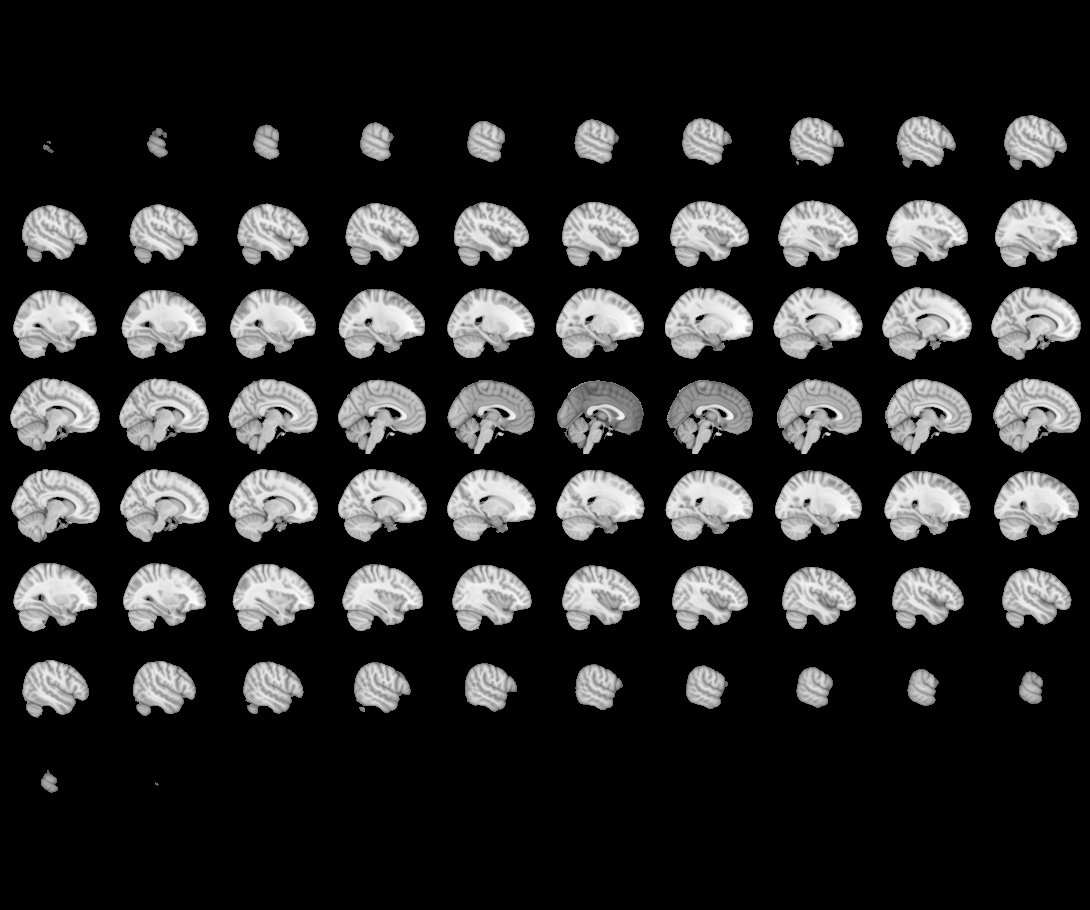
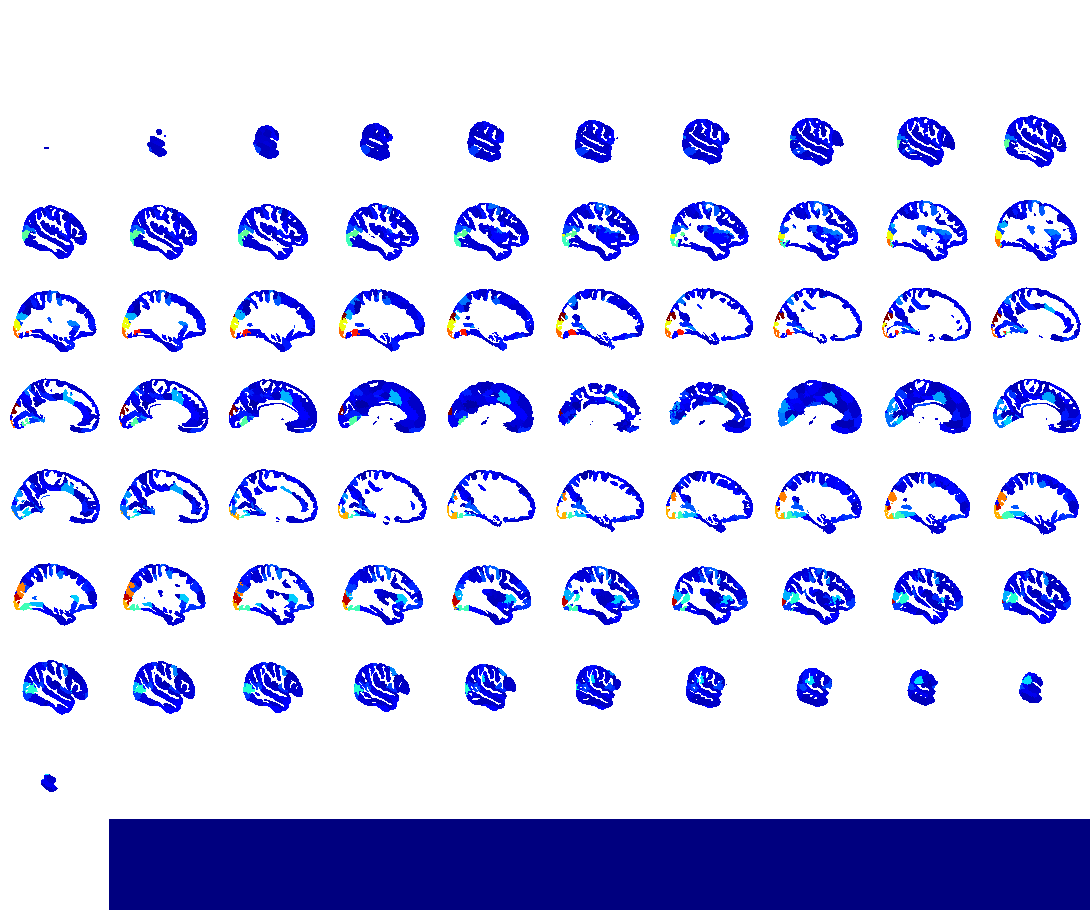

In [14]:
plotting.view_img(vols[0],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR1',cmap='jet')


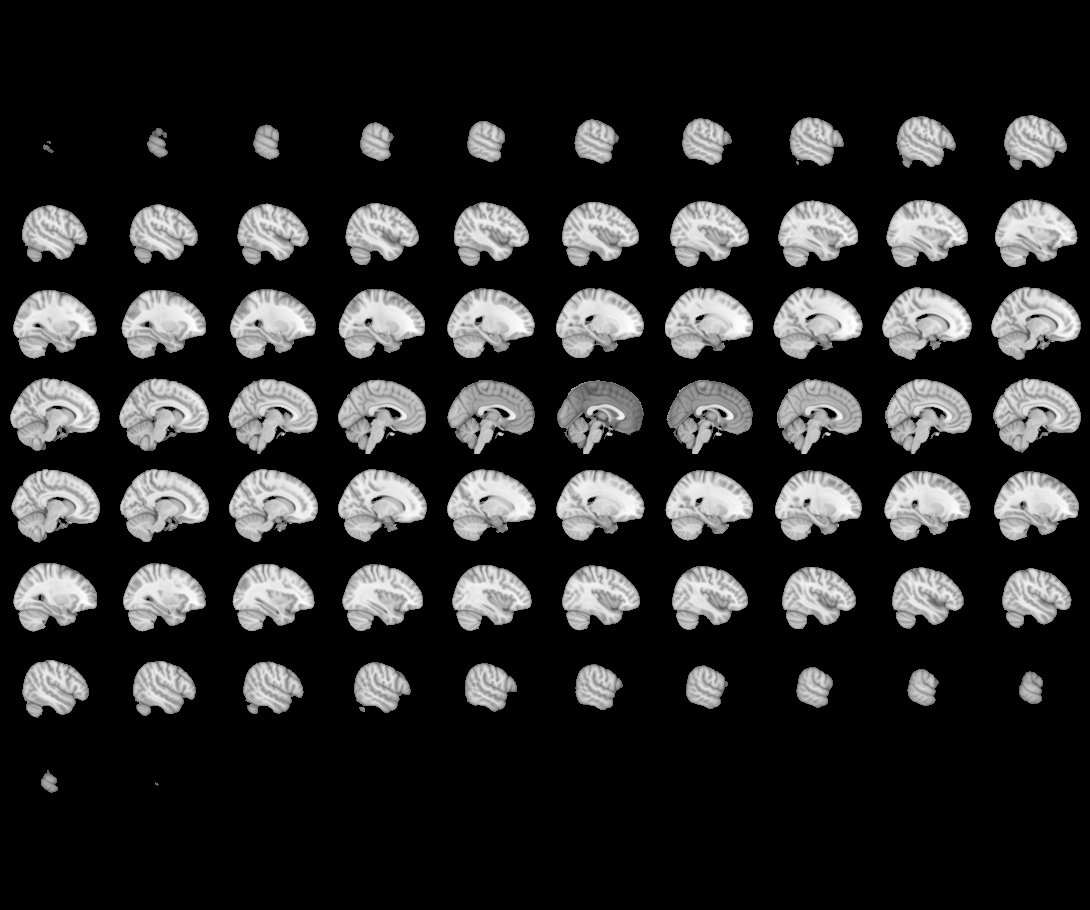
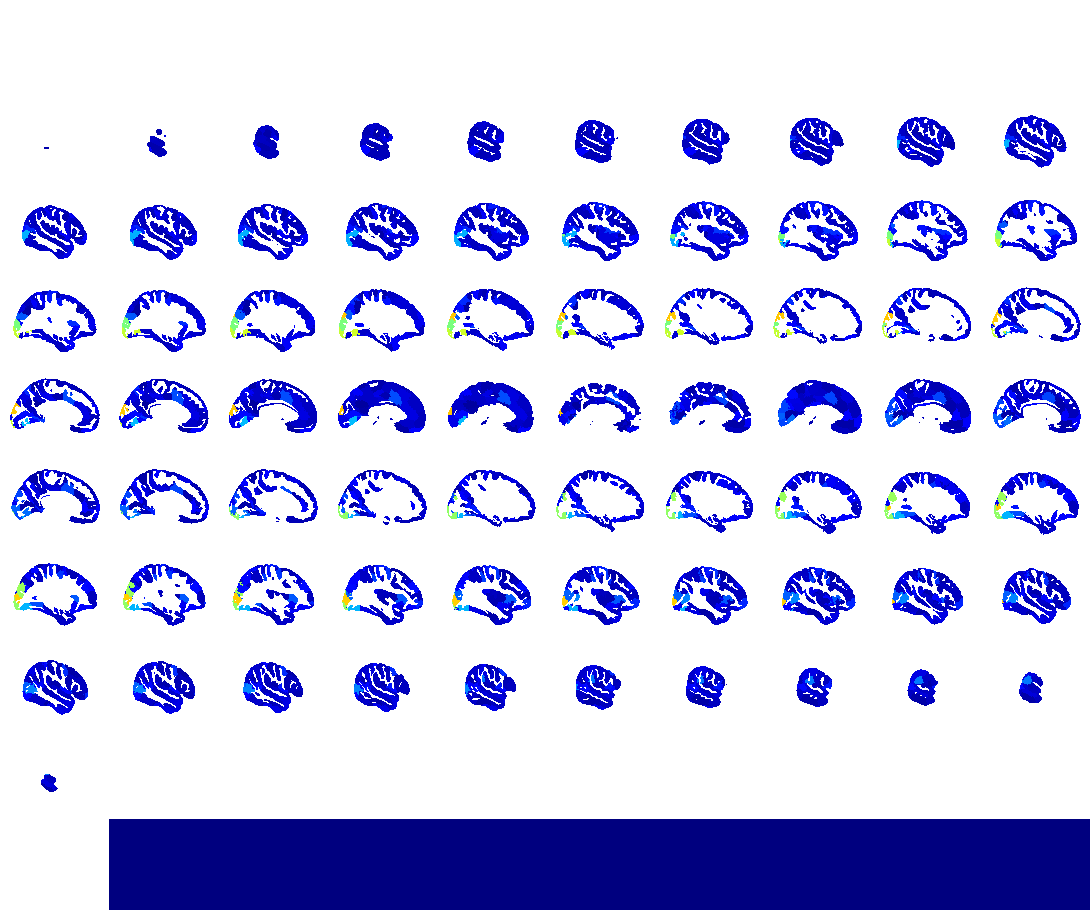

In [15]:
plotting.view_img(vols[1],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR2',cmap='jet')


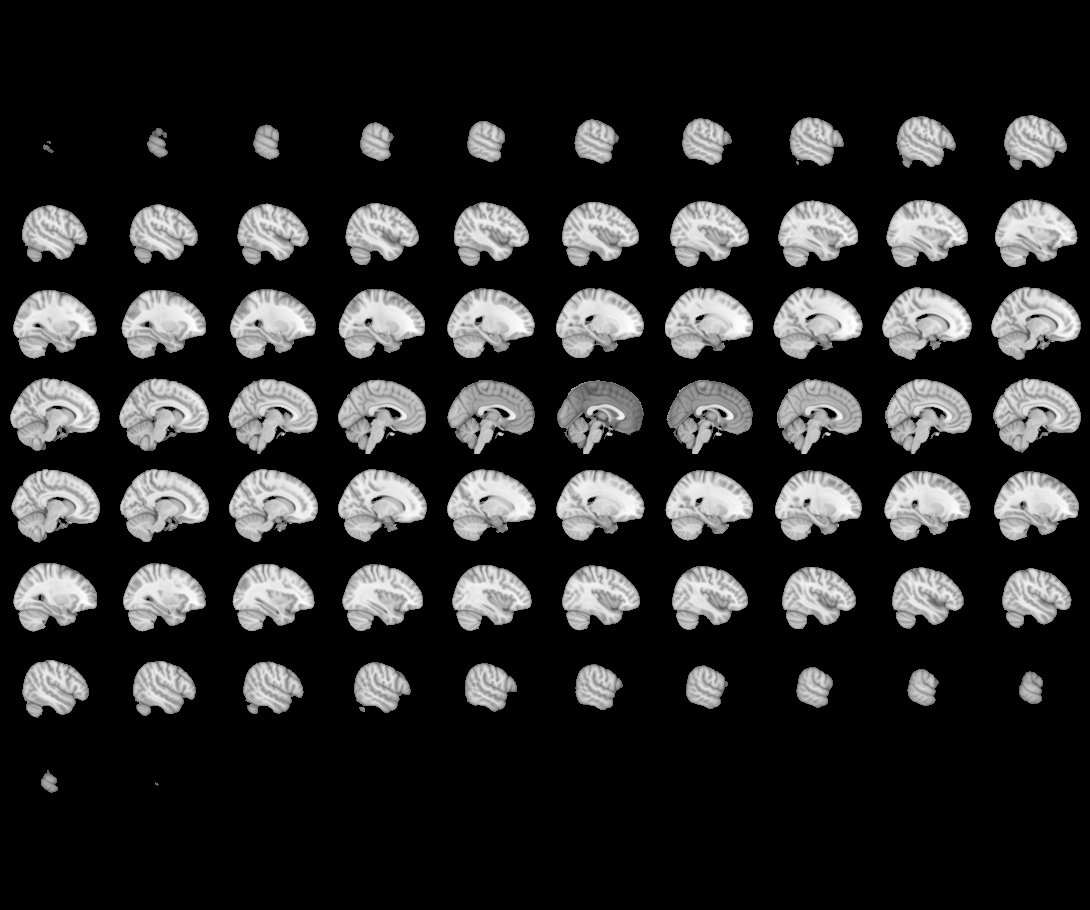
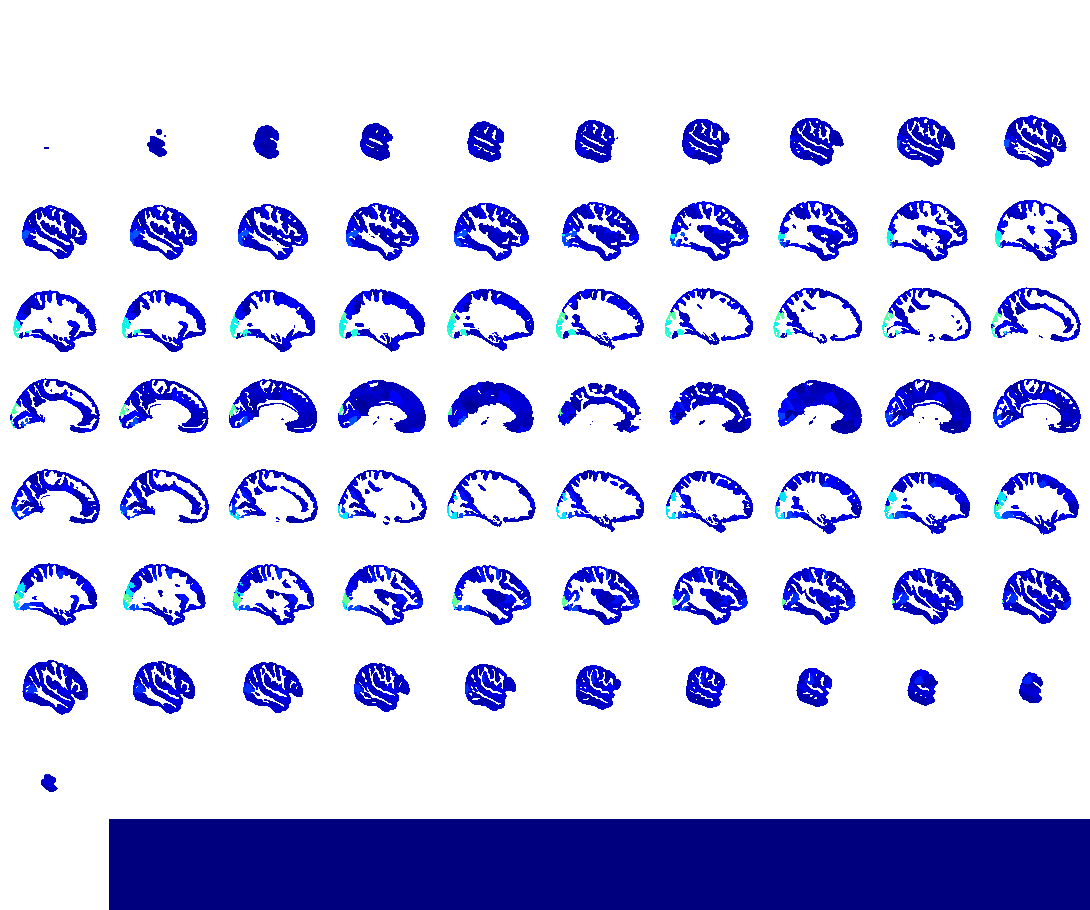

In [16]:
plotting.view_img(vols[2],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR3',cmap='jet')


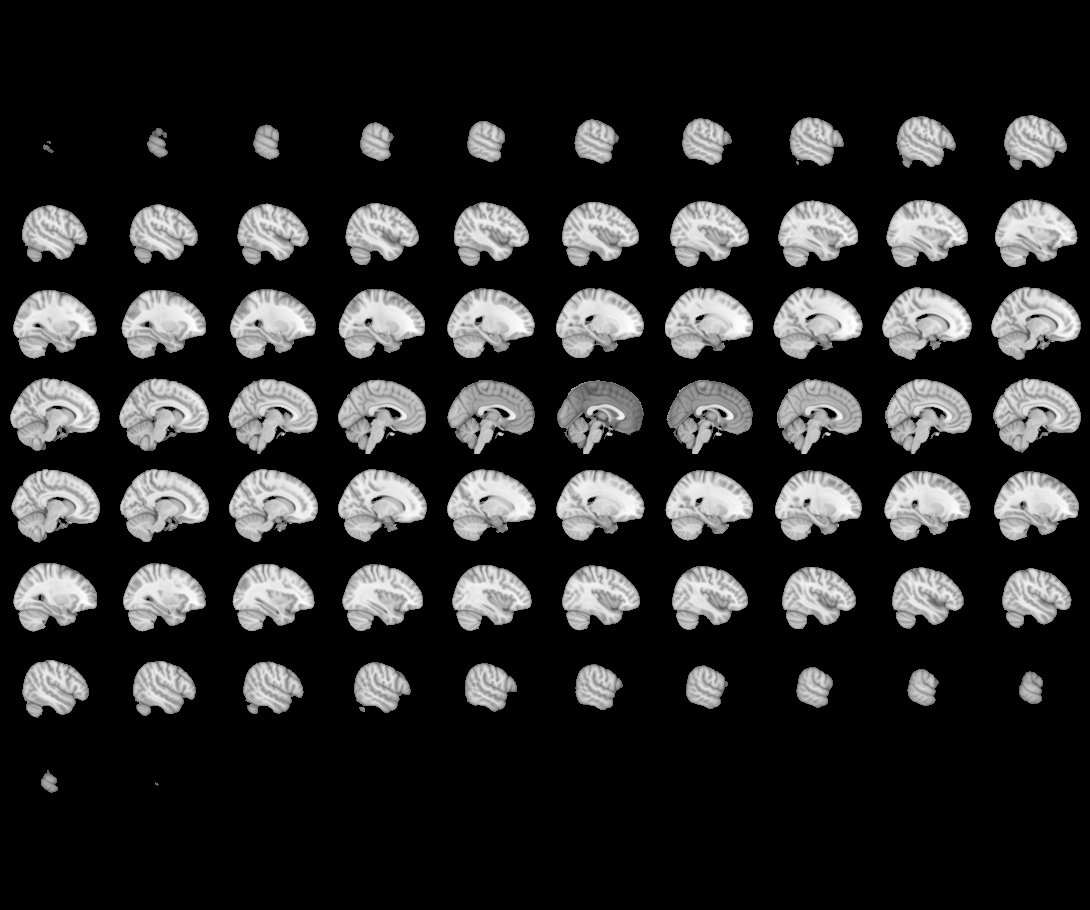
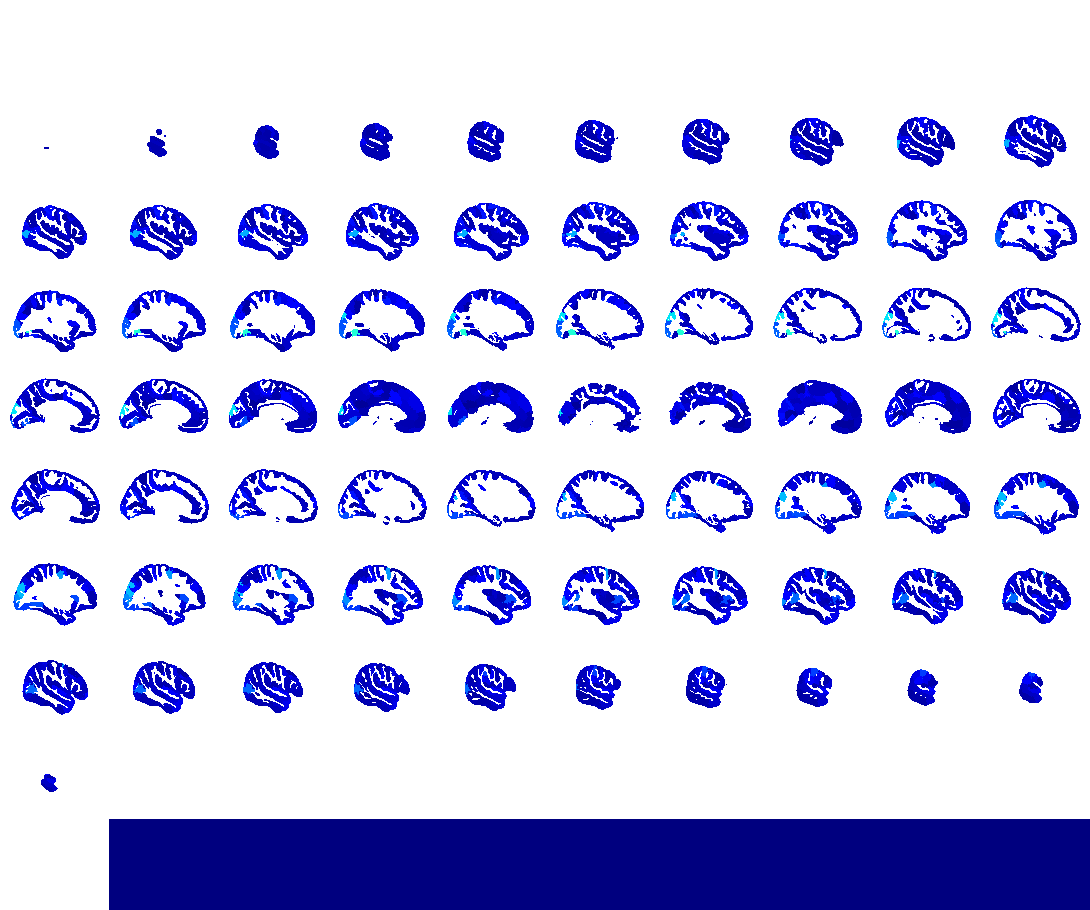

In [17]:
plotting.view_img(vols[3],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR4',cmap='jet')


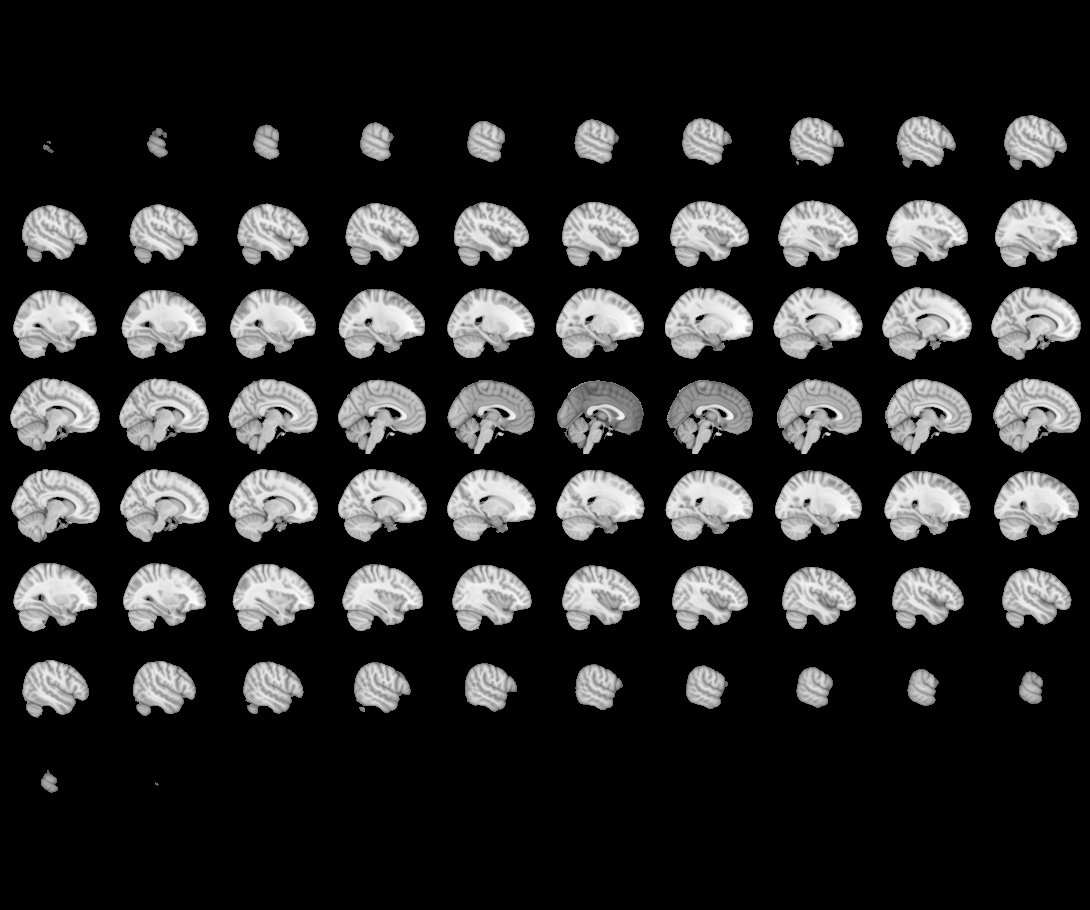
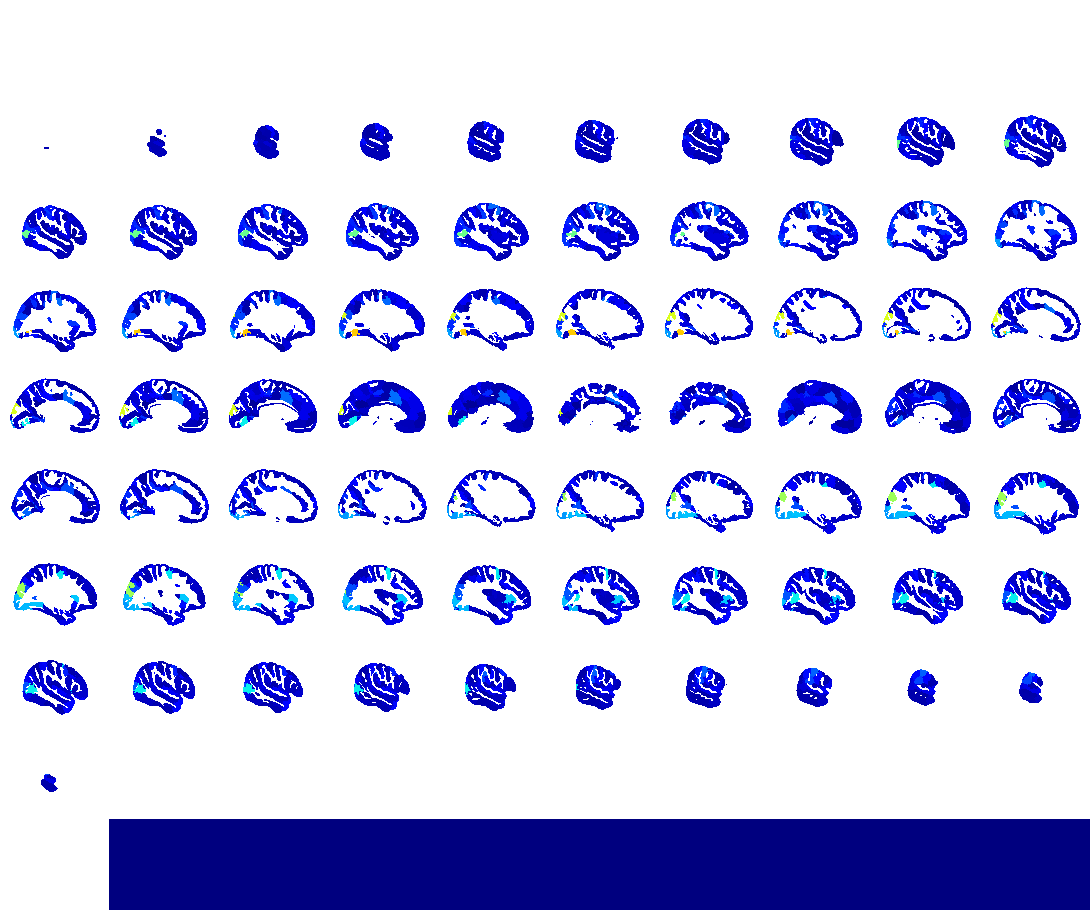

In [18]:
plotting.view_img(vols[4],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR5',cmap='jet')


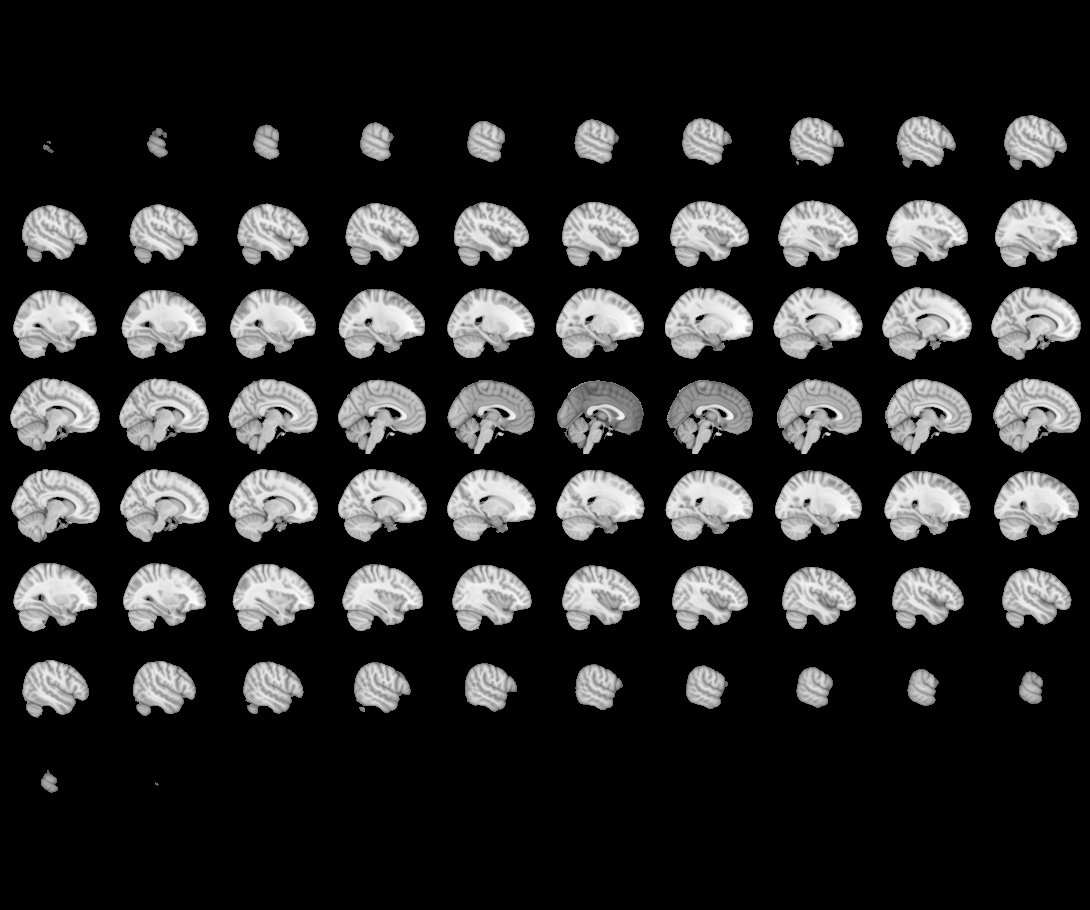
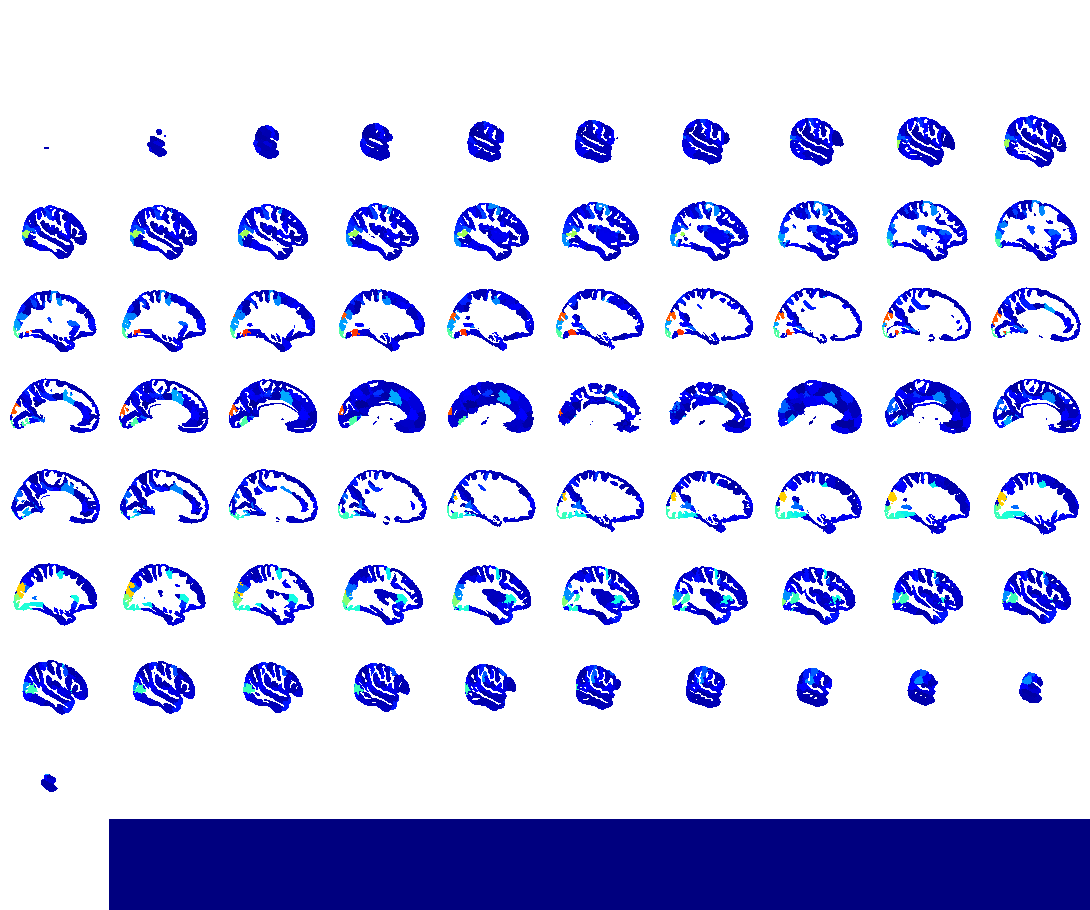

In [19]:
plotting.view_img(vols[5],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR6',cmap='jet')


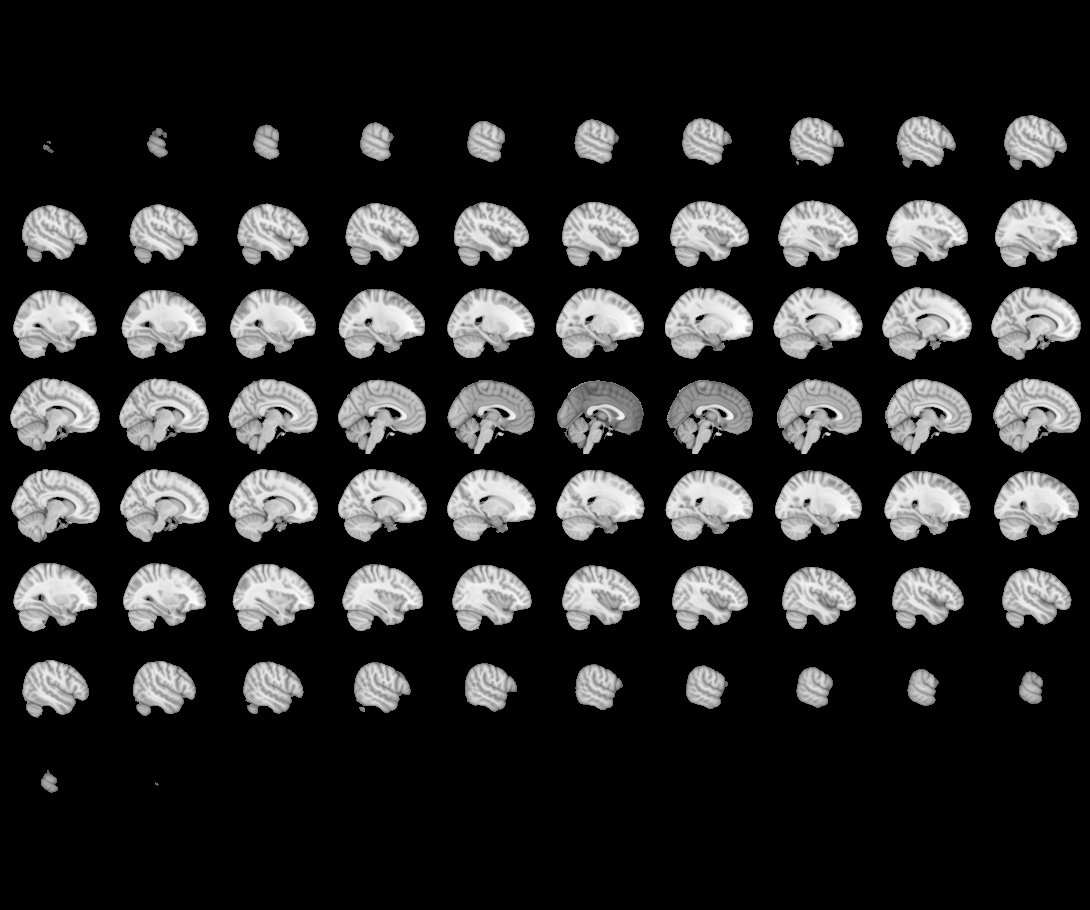
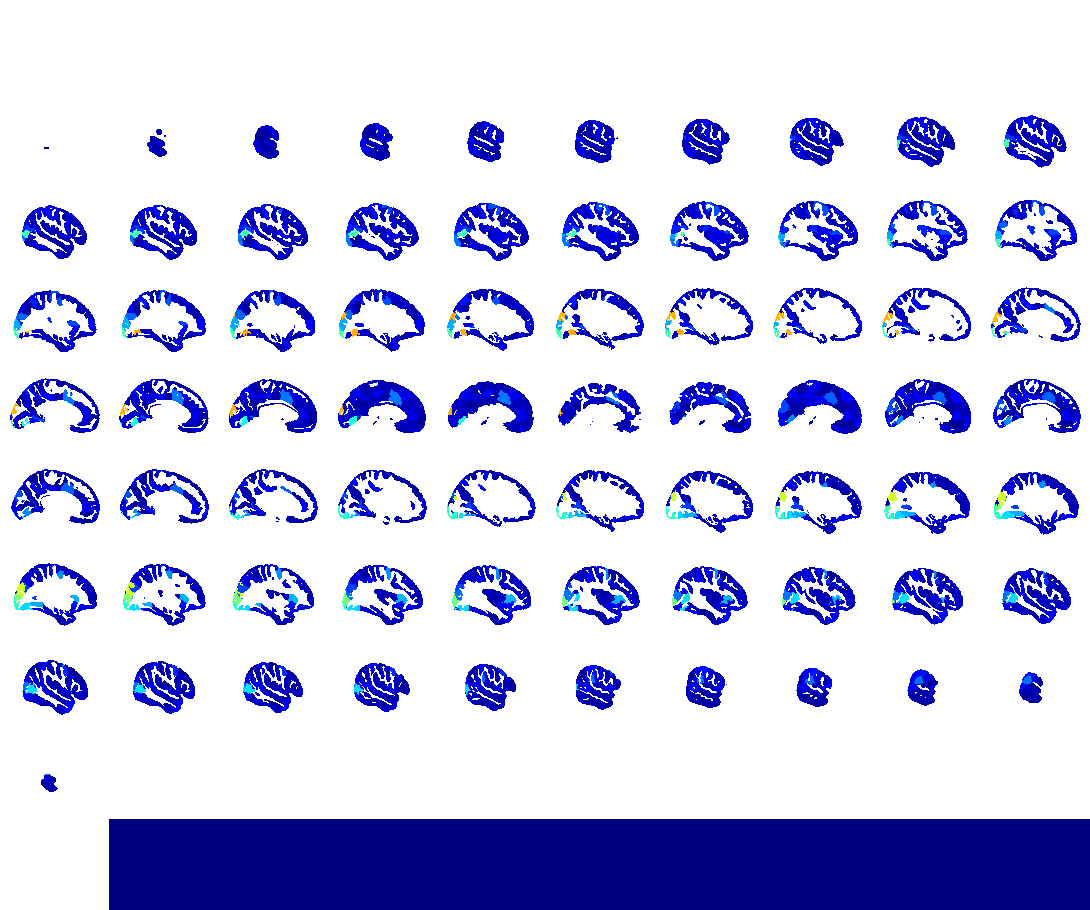

In [20]:
plotting.view_img(vols[6],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR7',cmap='jet')

In [13]:
mean_saliency_map.max()

0.6801264142087223